In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Maranhão - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_MA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Maranhão - Produção de Cimento (t),Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Maranhão - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Maranhão - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Maranhão - IDH Longevidade
0,2003-1,23.368400,1.609842e+06,0.614766,0.542831,8.213662,43.342,2.330394,1005.666766,5776.461493,26.995403,22.910306,79.260234,2.399209,10548.340000,0.260097,0.635570,4.315322e+07,2.636001e+06,6.034057,3.872495e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.722204
1,2003-2,23.167977,1.619288e+06,0.615338,0.543362,8.207986,28.663,2.330957,1005.664945,5776.461493,26.995348,22.913026,79.273296,2.397614,10647.107692,0.258964,0.635997,4.320832e+07,2.636851e+06,6.036083,3.874405e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.722513
2,2003-3,23.563273,1.628734e+06,0.615910,0.543892,8.202310,27.900,2.331285,1005.663882,5776.461493,26.995316,22.914612,79.280916,2.396684,10736.259174,0.257352,0.636424,4.326343e+07,2.637701e+06,6.038110,3.876316e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.722821
3,2003-4,24.008345,1.638180e+06,0.616483,0.544422,8.196633,25.739,2.331321,1005.663768,5776.461493,26.995312,22.914782,79.281732,2.396584,10818.881674,0.255929,0.636851,4.331853e+07,2.638551e+06,6.040136,3.878226e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.723129
4,2003-5,24.366896,1.647626e+06,0.617055,0.544953,8.190957,30.203,2.397956,1005.413091,6468.525319,26.849142,22.998258,80.364896,2.323932,10897.469605,0.254109,0.637278,4.337364e+07,2.639401e+06,6.042163,3.880136e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.723438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34913.291508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34868.689412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34805.943727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34730.731162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


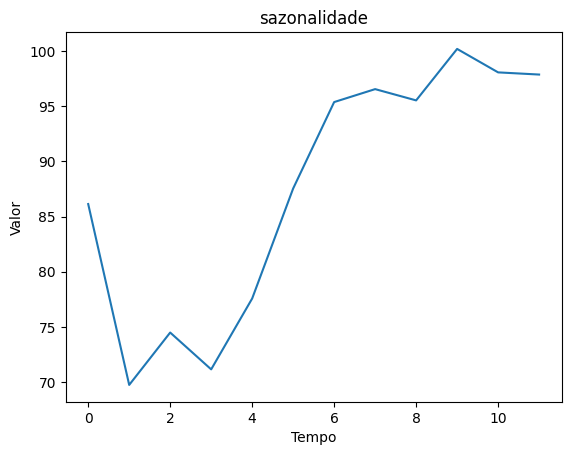

,sazonalidade
sazonalidade,
0,86.135612
1,69.738946
2,74.486678
3,71.148692
4,77.571487
5,87.544660
6,95.379343
7,96.552614
8,95.531187


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Maranhão - Produção de Cimento (t),Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Maranhão - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Maranhão - IDH Longevidade,sazonalidade,Maranhão - Consumo de Cimento (t)
0,2003-1,23.368400,1.609842e+06,0.614766,0.542831,8.213662,2.330394,1005.666766,5776.461493,26.995403,22.910306,79.260234,2.399209,10548.340000,0.260097,0.635570,4.315322e+07,2.636001e+06,6.034057,3.872495e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.722204,86.135612,43.342
1,2003-2,23.167977,1.619288e+06,0.615338,0.543362,8.207986,2.330957,1005.664945,5776.461493,26.995348,22.913026,79.273296,2.397614,10647.107692,0.258964,0.635997,4.320832e+07,2.636851e+06,6.036083,3.874405e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.722513,69.738946,28.663
2,2003-3,23.563273,1.628734e+06,0.615910,0.543892,8.202310,2.331285,1005.663882,5776.461493,26.995316,22.914612,79.280916,2.396684,10736.259174,0.257352,0.636424,4.326343e+07,2.637701e+06,6.038110,3.876316e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.722821,74.486678,27.900
3,2003-4,24.008345,1.638180e+06,0.616483,0.544422,8.196633,2.331321,1005.663768,5776.461493,26.995312,22.914782,79.281732,2.396584,10818.881674,0.255929,0.636851,4.331853e+07,2.638551e+06,6.040136,3.878226e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.723129,71.148692,25.739
4,2003-5,24.366896,1.647626e+06,0.617055,0.544953,8.190957,2.397956,1005.413091,6468.525319,26.849142,22.998258,80.364896,2.323932,10897.469605,0.254109,0.637278,4.337364e+07,2.639401e+06,6.042163,3.880136e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.723438,77.571487,30.203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34913.291508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.571487,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34868.689412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.544660,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34805.943727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.379343,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34730.731162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.552614,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      56.124
1      39.810
2      44.937
3      41.661
4      47.350
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Maranhão - Consumo de Cimento (t), Length: 249, dtype: float64

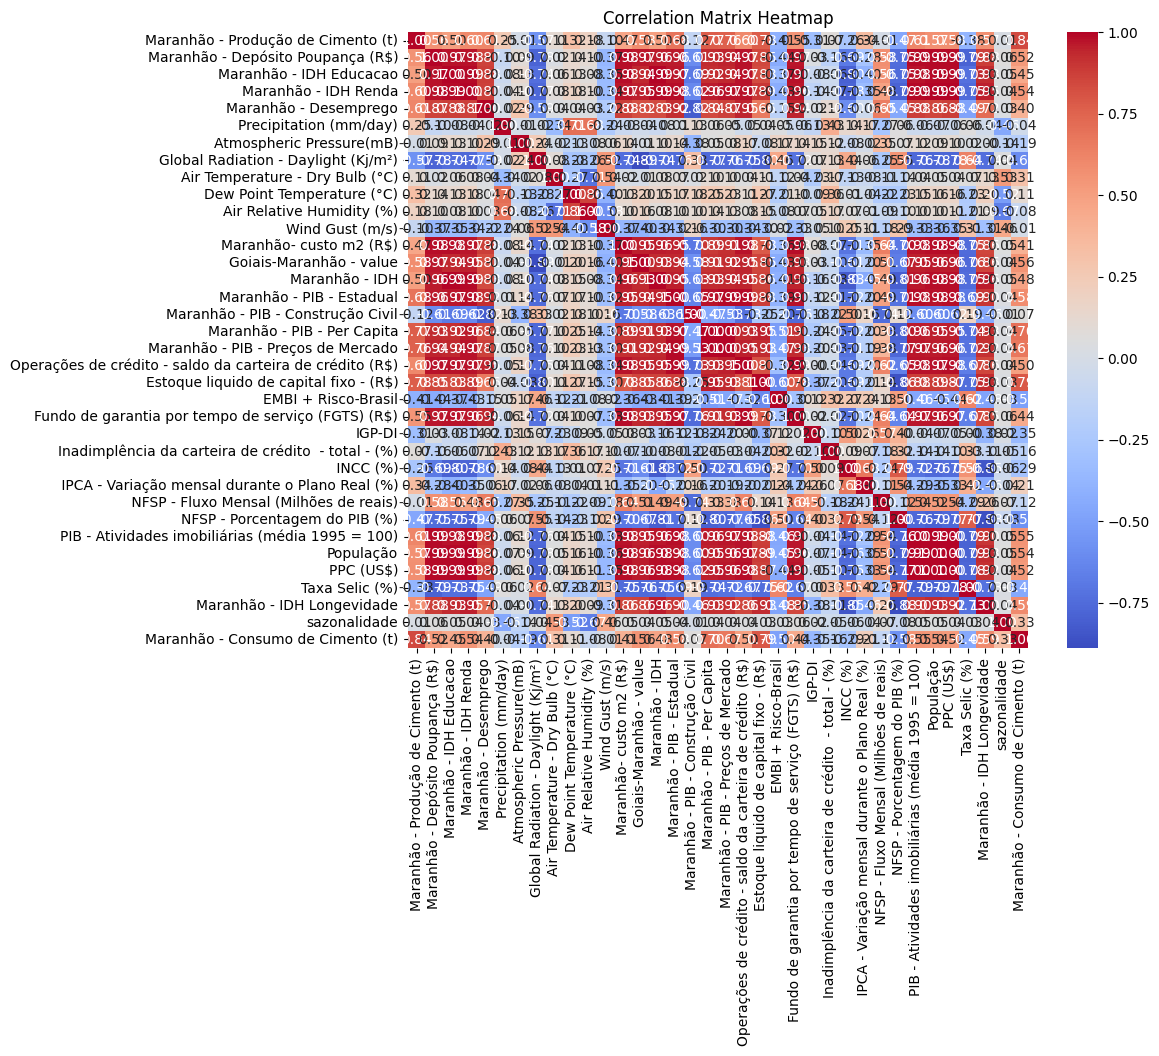

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Maranhão - Produção de Cimento (t),2.169324e+04
1,Maranhão - Depósito Poupança (R$),3.757774e+04
2,Maranhão - IDH Educacao,6.118809e+06
3,Maranhão - IDH Renda,1.218309e+05
4,Maranhão - Desemprego,5.680992e+04
5,Precipitation (mm/day),8.857304e+01
6,Atmospheric Pressure(mB),5.801124e+06
7,Global Radiation - Daylight (Kj/m²),1.263762e+02
8,Air Temperature - Dry Bulb (°C),5.388238e+05
9,Dew Point Temperature (°C),3.530329e+05


In [39]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 8


,Maranhão - Produção de Cimento (t),Maranhão - Depósito Poupança (R$),Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,23.368400,1.609842e+06,0.542831,8.213662,2.330394,5776.461493,26.995403,22.910306,79.260234,2.399209,10548.340000,0.260097,4.315322e+07,2.636001e+06,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,86.135612
1,23.167977,1.619288e+06,0.543362,8.207986,2.330957,5776.461493,26.995348,22.913026,79.273296,2.397614,10647.107692,0.258964,4.320832e+07,2.636851e+06,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,69.738946
2,23.563273,1.628734e+06,0.543892,8.202310,2.331285,5776.461493,26.995316,22.914612,79.280916,2.396684,10736.259174,0.257352,4.326343e+07,2.637701e+06,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,74.486678
3,24.008345,1.638180e+06,0.544422,8.196633,2.331321,5776.461493,26.995312,22.914782,79.281732,2.396584,10818.881674,0.255929,4.331853e+07,2.638551e+06,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,71.148692
4,24.366896,1.647626e+06,0.544953,8.190957,2.397956,6468.525319,26.849142,22.998258,80.364896,2.323932,10897.469605,0.254109,4.337364e+07,2.639401e+06,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,77.571487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,29.888073,6.199296e+06,0.604986,12.108100,1.603956,1510.895625,27.021053,22.967680,79.472254,1.552539,27029.118496,0.399245,5.139501e+07,2.593599e+06,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,96.552614
200,29.866245,6.318524e+06,0.604928,12.094340,1.655927,1658.765770,27.266990,22.914721,78.044948,1.664999,27230.854038,0.401743,5.135414e+07,2.595464e+06,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,95.531187
201,30.021068,6.437751e+06,0.604870,12.080580,1.443480,1699.247291,27.232597,23.050410,78.860440,1.774648,27437.712061,0.404621,5.131327e+07,2.597330e+06,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,100.197113
202,29.938443,6.556979e+06,0.604813,12.066820,1.348573,1771.596089,27.123952,23.278456,80.446682,1.843590,27651.325327,0.407586,5.127240e+07,2.599196e+06,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,98.070711


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Maranhão - Depósito Poupança (R$),Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.734741,-2.048695,-0.883512,-0.145082,0.060536,0.135627,-0.735363,-0.631331,0.751284,-1.613322,-1.004880,-1.743384,-0.207794,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-1.727440,-2.021738,-0.886324,-0.144093,0.060536,0.135491,-0.730703,-0.627769,0.748209,-1.592553,-1.024709,-1.725633,-0.190940,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-1.720138,-1.994782,-0.889135,-0.143516,0.060536,0.135411,-0.727985,-0.625691,0.746415,-1.573807,-1.052883,-1.707882,-0.174085,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-1.712836,-1.967826,-0.891947,-0.143455,0.060536,0.135403,-0.727694,-0.625468,0.746222,-1.556433,-1.077772,-1.690131,-0.157230,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-1.705534,-1.940869,-0.894759,-0.026482,0.166332,-0.225539,-0.584665,-0.330041,0.606130,-1.539908,-1.109596,-1.672380,-0.140376,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.812935,1.110118,1.045577,-1.420277,-0.591548,0.198965,-0.637058,-0.573504,-0.881331,1.852204,1.428255,0.911538,-1.048506,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.402207,-1.370268
200,1.905099,1.107188,1.038761,-1.329048,-0.568943,0.806265,-0.727799,-0.962795,-0.664477,1.894624,1.471925,0.898373,-1.011510,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.410056,-1.390925
201,1.997262,1.104258,1.031945,-1.701978,-0.562754,0.721337,-0.495309,-0.740373,-0.453043,1.938122,1.522255,0.885208,-0.974514,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.417346,-1.527663
202,2.089426,1.101328,1.025129,-1.868579,-0.551694,0.453056,-0.104576,-0.307734,-0.320104,1.983040,1.574096,0.872044,-0.937518,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.423988,-1.609340


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Maranhão - Depósito Poupança (R$),Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.734741,-2.048695,-0.883512,-0.145082,0.060536,0.135627,-0.735363,-0.631331,0.751284,-1.613322,-1.004880,-1.743384,-0.207794,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-1.727440,-2.021738,-0.886324,-0.144093,0.060536,0.135491,-0.730703,-0.627769,0.748209,-1.592553,-1.024709,-1.725633,-0.190940,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-1.720138,-1.994782,-0.889135,-0.143516,0.060536,0.135411,-0.727985,-0.625691,0.746415,-1.573807,-1.052883,-1.707882,-0.174085,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-1.712836,-1.967826,-0.891947,-0.143455,0.060536,0.135403,-0.727694,-0.625468,0.746222,-1.556433,-1.077772,-1.690131,-0.157230,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-1.705534,-1.940869,-0.894759,-0.026482,0.166332,-0.225539,-0.584665,-0.330041,0.606130,-1.539908,-1.109596,-1.672380,-0.140376,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.131878,1.149355,1.116904,-0.263996,-0.613056,-0.094803,-1.083462,-0.758474,0.202518,1.471433,1.094687,1.064574,-1.449061,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.279826,-1.152820
188,1.139061,1.145610,1.112181,-0.277344,-0.613951,0.073544,-1.049064,-0.819884,0.290645,1.494570,1.109879,1.052398,-1.420744,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.291262,-1.253503
189,1.146243,1.141865,1.107458,-1.036587,-0.616462,0.225935,-0.750520,-0.684336,0.242690,1.517849,1.125215,1.040221,-1.392427,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.301919,-1.425444
190,1.153425,1.138120,1.102735,-1.040522,-0.622047,-0.024122,-0.331578,-0.249539,0.023313,1.540777,1.147835,1.028045,-1.364111,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.311660,-1.237935


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       56.124
1       39.810
2       44.937
3       41.661
4       47.350
        ...   
187    108.451
188    107.233
189    113.345
190     94.561
191     89.227
Name: Maranhão - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 25)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Maranhão - Depósito Poupança (R$),Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
156,0.744592,1.237935,1.369660,0.236730,-0.632597,0.974792,0.666188,0.001392,-0.028013,0.849039,0.819009,1.139542,-1.514395,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.911463,0.407265
157,0.759278,1.235818,1.357185,0.539085,-0.636352,0.834946,1.093859,0.399035,-0.389089,0.869075,0.826922,1.142464,-1.531613,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.922870,0.137084
158,0.773965,1.233700,1.344709,1.020564,-0.638894,0.602774,1.242600,0.636869,-0.693453,0.888266,0.834918,1.145386,-1.548832,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.935360,0.296087
159,0.788651,1.231583,1.332234,0.735574,-0.634573,0.446270,1.129911,0.636869,-0.829530,0.905936,0.843002,1.148307,-1.566051,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.948135,0.197300
160,0.803338,1.229466,1.319759,0.853296,-0.629949,0.304808,0.743500,0.415241,-0.731054,0.924284,0.851106,1.151229,-1.583269,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.961143,0.469403
161,0.818024,1.227348,1.307283,0.389080,-0.621178,0.303854,0.223295,0.021521,-0.451172,0.942194,0.859231,1.154151,-1.600488,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.973478,0.775434
162,0.832711,1.225231,1.294808,0.051458,-0.609735,0.646279,-0.228486,-0.487889,-0.009775,0.961234,0.866649,1.157073,-1.617706,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.985778,0.136553
163,0.847397,1.223114,1.282333,0.249609,-0.603115,1.227987,-0.614232,-1.072727,0.505936,0.978892,0.874859,1.159995,-1.634925,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.999021,0.642038
164,0.862084,1.220996,1.269857,-0.620792,-0.602710,1.603650,-0.694740,-1.321717,0.761920,0.997568,0.883020,1.162917,-1.652144,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,1.012408,0.482412
165,0.876770,1.218879,1.257382,-0.033058,-0.609195,1.595545,-0.481475,-1.153499,0.700196,1.017538,0.891133,1.165838,-1.669362,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.025524,0.367764


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 25)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(180, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3589212268, 2111480276, 2904851531, 939478590, 2544534716, 2356268463, 2457228548, 2170198649, 371416449, 3636956535]


Step: 0 ___________________________________________
val_loss: 498.3189392089844
winner_seed: 3589212268


Step: 1 ___________________________________________
val_loss: 425.81475830078125
winner_seed: 2111480276


Step: 2 ___________________________________________
val_loss: 470.3290710449219


Step: 3 ___________________________________________
val_loss: 543.02490234375


Step: 4 ___________________________________________
val_loss: 626.15234375


Step: 5 ___________________________________________
val_loss: 542.1660766601562


Step: 6 ___________________________________________
val_loss: 532.8936767578125


Step: 7 ___________________________________________
val_loss: 578.3556518554688


Step: 8 ___________________________________________
val_loss: 416.8318176269531
winner_seed: 371416449


Step: 9 ___________________________________________
val_loss: 692.0267333984

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 394904081

Epoch 1/10000
5/5 [==============================] - 2s 94ms/step - loss: 6562.7607 - val_loss: 524.4216
Epoch 2/10000
5/5 [==============================] - 0s 8ms/step - loss: 960.6836 - val_loss: 559.3423
Epoch 3/10000
5/5 [==============================] - 0s 8ms/step - loss: 793.9888 - val_loss: 501.7686
Epoch 4/10000
5/5 [==============================] - 0s 7ms/step - loss: 908.4384 - val_loss: 500.5467
Epoch 5/10000
5/5 [==============================] - 0s 7ms/step - loss: 1025.9904 - val_loss: 1534.2356
Epoch 6/10000
5/5 [==============================] - 0s 7ms/step - loss: 754.5981 - val_loss: 6198.0542
Epoch 7/10000
5/5 [==============================] - 0s 7ms/step - loss: 500.9637 - val_loss: 8751.6836
Epoch 8/10000
5/5 [==============================] - 0s 8ms/step - loss: 829.3380 - val_loss: 467.6339
Epoch 9/10000
5/5 [==============================] - 0s 8ms/step - loss: 692.1101 - val_loss: 689.5570
Epoch 10/10000
5/5 [==============================] - 0s 8ms/step -

5/5 [==============================] - 0s 9ms/step - loss: 58.8001 - val_loss: 746.4717
Epoch 81/10000
5/5 [==============================] - 0s 10ms/step - loss: 65.0420 - val_loss: 549.8159
Epoch 82/10000
5/5 [==============================] - 0s 9ms/step - loss: 48.0988 - val_loss: 602.5153
Epoch 83/10000
5/5 [==============================] - 0s 9ms/step - loss: 63.6642 - val_loss: 575.1505
Epoch 84/10000
5/5 [==============================] - 0s 9ms/step - loss: 55.1782 - val_loss: 566.5102
Epoch 85/10000
5/5 [==============================] - 0s 9ms/step - loss: 54.7152 - val_loss: 869.5092
Epoch 86/10000
5/5 [==============================] - 0s 9ms/step - loss: 59.0544 - val_loss: 532.5623
Epoch 87/10000
5/5 [==============================] - 0s 9ms/step - loss: 55.3386 - val_loss: 576.8778
Epoch 88/10000
5/5 [==============================] - 0s 9ms/step - loss: 73.7184 - val_loss: 754.1437
Epoch 89/10000
5/5 [==============================] - 0s 8ms/step - loss: 59.8937 - val

5/5 [==============================] - 0s 8ms/step - loss: 57.6559 - val_loss: 593.0258
Epoch 160/10000
5/5 [==============================] - 0s 8ms/step - loss: 40.3293 - val_loss: 758.3422
Epoch 161/10000
5/5 [==============================] - 0s 8ms/step - loss: 37.1675 - val_loss: 584.5149
Epoch 162/10000
5/5 [==============================] - 0s 7ms/step - loss: 40.3097 - val_loss: 674.7533
Epoch 163/10000
5/5 [==============================] - 0s 8ms/step - loss: 36.5982 - val_loss: 722.0280
Epoch 164/10000
5/5 [==============================] - 0s 8ms/step - loss: 34.1362 - val_loss: 625.6202
Epoch 165/10000
5/5 [==============================] - 0s 8ms/step - loss: 36.3367 - val_loss: 729.4172
Epoch 166/10000
5/5 [==============================] - 0s 8ms/step - loss: 43.7946 - val_loss: 715.3706
Epoch 167/10000
5/5 [==============================] - 0s 8ms/step - loss: 32.8265 - val_loss: 748.4866
Epoch 168/10000
5/5 [==============================] - 0s 8ms/step - loss: 35.86

Epoch 238/10000
5/5 [==============================] - 0s 9ms/step - loss: 40.8329 - val_loss: 627.0772
Epoch 239/10000
5/5 [==============================] - 0s 8ms/step - loss: 31.1241 - val_loss: 637.2166
Epoch 240/10000
5/5 [==============================] - 0s 8ms/step - loss: 27.5804 - val_loss: 751.6882
Epoch 241/10000
5/5 [==============================] - 0s 8ms/step - loss: 30.2034 - val_loss: 667.4393
Epoch 242/10000
5/5 [==============================] - 0s 7ms/step - loss: 30.3503 - val_loss: 809.7109
Epoch 243/10000
5/5 [==============================] - 0s 8ms/step - loss: 35.3095 - val_loss: 605.2285
Epoch 244/10000
5/5 [==============================] - 0s 8ms/step - loss: 31.3516 - val_loss: 589.5021
Epoch 245/10000
5/5 [==============================] - 0s 8ms/step - loss: 37.4277 - val_loss: 653.5914
Epoch 246/10000
5/5 [==============================] - 0s 9ms/step - loss: 31.6206 - val_loss: 758.1599
Epoch 247/10000
5/5 [==============================] - 0s 8ms/st

Epoch 317/10000
5/5 [==============================] - 0s 8ms/step - loss: 22.7123 - val_loss: 586.8110
Epoch 318/10000
5/5 [==============================] - 0s 8ms/step - loss: 26.4707 - val_loss: 591.2092
Epoch 319/10000
5/5 [==============================] - 0s 8ms/step - loss: 20.1473 - val_loss: 696.9522
Epoch 320/10000
5/5 [==============================] - 0s 8ms/step - loss: 22.1485 - val_loss: 769.8135
Epoch 321/10000
5/5 [==============================] - 0s 9ms/step - loss: 23.7245 - val_loss: 569.2474
Epoch 322/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.8583 - val_loss: 646.7534
Epoch 323/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.4368 - val_loss: 638.1188
Epoch 324/10000
5/5 [==============================] - 0s 9ms/step - loss: 25.7600 - val_loss: 668.5818
Epoch 325/10000
5/5 [==============================] - 0s 8ms/step - loss: 23.9415 - val_loss: 636.8653
Epoch 326/10000
5/5 [==============================] - 0s 8ms/st

Epoch 396/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.3530 - val_loss: 597.1475
Epoch 397/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.7059 - val_loss: 594.2479
Epoch 398/10000
5/5 [==============================] - 0s 8ms/step - loss: 17.9618 - val_loss: 564.5197
Epoch 399/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.6089 - val_loss: 591.6923
Epoch 400/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.4920 - val_loss: 555.4557
Epoch 401/10000
5/5 [==============================] - 0s 8ms/step - loss: 17.5404 - val_loss: 544.1121
Epoch 402/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.3292 - val_loss: 516.9600
Epoch 403/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.6803 - val_loss: 607.2505
Epoch 404/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.3891 - val_loss: 577.5267
Epoch 405/10000
5/5 [==============================] - 0s 8ms/st

Epoch 475/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.6587 - val_loss: 546.6582
Epoch 476/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.3882 - val_loss: 583.7999
Epoch 477/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.9357 - val_loss: 640.5008
Epoch 478/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.6528 - val_loss: 526.5897
Epoch 479/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.4264 - val_loss: 541.2426
Epoch 480/10000
5/5 [==============================] - 0s 7ms/step - loss: 24.7646 - val_loss: 550.9481
Epoch 481/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.8892 - val_loss: 613.5894
Epoch 482/10000
5/5 [==============================] - 0s 8ms/step - loss: 17.1050 - val_loss: 544.1767
Epoch 483/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.0072 - val_loss: 537.5945
Epoch 484/10000
5/5 [==============================] - 0s 8ms/st

Epoch 554/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.3218 - val_loss: 479.3525
Epoch 555/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.0146 - val_loss: 502.5983
Epoch 556/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.7497 - val_loss: 530.3397
Epoch 557/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.8529 - val_loss: 552.9799
Epoch 558/10000
5/5 [==============================] - 0s 7ms/step - loss: 14.5031 - val_loss: 691.0831
Epoch 559/10000
5/5 [==============================] - 0s 8ms/step - loss: 20.9926 - val_loss: 513.7273
Epoch 560/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.0816 - val_loss: 571.9831
Epoch 561/10000
5/5 [==============================] - 0s 8ms/step - loss: 16.7918 - val_loss: 614.5567
Epoch 562/10000
5/5 [==============================] - 0s 8ms/step - loss: 12.8482 - val_loss: 583.7238
Epoch 563/10000
5/5 [==============================] - 0s 8ms/st

Epoch 633/10000
5/5 [==============================] - 0s 7ms/step - loss: 14.0867 - val_loss: 561.2075
Epoch 634/10000
5/5 [==============================] - 0s 7ms/step - loss: 12.3371 - val_loss: 608.9271
Epoch 635/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.4236 - val_loss: 594.5533
Epoch 636/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.3647 - val_loss: 632.8068
Epoch 637/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.0012 - val_loss: 534.0193
Epoch 638/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.6157 - val_loss: 622.3841
Epoch 639/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.0901 - val_loss: 597.5014
Epoch 640/10000
5/5 [==============================] - 0s 7ms/step - loss: 12.8592 - val_loss: 566.7062
Epoch 641/10000
5/5 [==============================] - 0s 8ms/step - loss: 12.9625 - val_loss: 620.3347
Epoch 642/10000
5/5 [==============================] - 0s 8ms/st

Epoch 712/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.4157 - val_loss: 549.6029
Epoch 713/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.2612 - val_loss: 667.9785
Epoch 714/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.9799 - val_loss: 637.6149
Epoch 715/10000
5/5 [==============================] - 0s 8ms/step - loss: 13.5678 - val_loss: 585.3920
Epoch 716/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.8644 - val_loss: 662.4723
Epoch 717/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.6547 - val_loss: 568.3511
Epoch 718/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.1990 - val_loss: 650.1578
Epoch 719/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.7189 - val_loss: 559.6367
Epoch 720/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.8727 - val_loss: 587.9525
Epoch 721/10000
5/5 [==============================] - 0s 7ms/st

Epoch 791/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.9814 - val_loss: 687.4861
Epoch 792/10000
5/5 [==============================] - 0s 8ms/step - loss: 16.4982 - val_loss: 535.3282
Epoch 793/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.9929 - val_loss: 571.0062
Epoch 794/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.9723 - val_loss: 635.1544
Epoch 795/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.2076 - val_loss: 702.9657
Epoch 796/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.9252 - val_loss: 603.1321
Epoch 797/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.4263 - val_loss: 714.0030
Epoch 798/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.7593 - val_loss: 598.2518
Epoch 799/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.8329 - val_loss: 601.0818
Epoch 800/10000
5/5 [==============================] - 0s 7ms/step

Epoch 870/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.4308 - val_loss: 663.6765
Epoch 871/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.1043 - val_loss: 683.0125
Epoch 872/10000
5/5 [==============================] - 0s 7ms/step - loss: 12.5385 - val_loss: 640.8681
Epoch 873/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.3852 - val_loss: 620.0598
Epoch 874/10000
5/5 [==============================] - 0s 7ms/step - loss: 12.0863 - val_loss: 614.0883
Epoch 875/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.6839 - val_loss: 643.6706
Epoch 876/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.4673 - val_loss: 681.2982
Epoch 877/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.8461 - val_loss: 615.5103
Epoch 878/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.6506 - val_loss: 633.2911
Epoch 879/10000
5/5 [==============================] - 0s 8ms/step 

5/5 [==============================] - 0s 8ms/step - loss: 9.2638 - val_loss: 645.4491
Epoch 950/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.9341 - val_loss: 644.3588
Epoch 951/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.0205 - val_loss: 670.4055
Epoch 952/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.1051 - val_loss: 618.6304
Epoch 953/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.3078 - val_loss: 638.6888
Epoch 954/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.8678 - val_loss: 622.9156
Epoch 955/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.7456 - val_loss: 589.0386
Epoch 956/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.9161 - val_loss: 622.0534
Epoch 957/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.0257 - val_loss: 676.7343
Epoch 958/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.3365 - val_

5/5 [==============================] - 0s 7ms/step - loss: 11.1555 - val_loss: 690.5897
Epoch 1029/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.6160 - val_loss: 650.2377
Epoch 1030/10000
5/5 [==============================] - 0s 7ms/step - loss: 8.3311 - val_loss: 650.1392
Epoch 1031/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.0562 - val_loss: 623.4031
Epoch 1032/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.7068 - val_loss: 630.2947
Epoch 1033/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.3450 - val_loss: 661.6633
Epoch 1034/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.4067 - val_loss: 608.4255
Epoch 1035/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.3925 - val_loss: 652.5258
Epoch 1036/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.1837 - val_loss: 587.3087
Epoch 1037/10000
5/5 [==============================] - 0s 7ms/step - loss: 8.24

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,79.569847,83.785057,88.913933,88.226906,88.470436,91.452858,94.308708,95.541496,94.645157,93.387482,94.68795,95.588333
Target,82.674,69.076,72.303,75.399,89.958,87.816,100.404,98.719,94.675,95.575,102.533,89.997
Error,3.104156,14.709061,16.610931,12.827904,1.487564,3.636856,6.095291,3.177505,0.029846,2.187515,7.845047,5.591331


In [54]:
display(mae)
display(mape)

6.4419174

0.08025422

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[1088.5781]] - Target[1059.129]| =  Error: [[29.449097]]; MAPE:[[0.02780501]]


[array([[29.449097]], dtype=float32)]

29.449097

0.027805014